<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/Miniproyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Montar el Google Drive en el directorio del proyecto y descomprimir el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/vision-artificial.zip' >> /dev/null  # ACTUALIZAR: ruta al fichero comprimido


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/gdrive


In [78]:
# Especificar las rutas al directorio con las imágenes y al fichero con las etiquetas
imgtrain_dir = "/content/train/images/"
imgtrainmask_dir = "/content/train/masks/"
csvtrain_file = "/content/train.csv"

imgtest_dir = "/content/train.csv"
csvtest_file = "/content/test.csv"
# Leer el fichero CSV con las etiquetas
df = pd.read_csv(csvtrain_file, dtype={"class": "category"})
dftest = pd.read_csv(csvtest_file, dtype={"class": "category"})

# Codificar las etiquetas utilizando LabelEncoder
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])


In [79]:
# Dividir el conjunto en entrenamiento, validación y test (80:10:10)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.2)

df = df.sample(frac=1).reset_index(drop=True)  # barajar el dataframe
dftest = df[:test_size]
dfval = df[test_size:test_size+val_size]
dftrain = df[test_size+val_size:]

print(f'Número de ejemplos del conjunto de entrenamiento: {dftrain.shape[0]}')
print(f'Número de ejemplos del conjunto de validación: {dfval.shape[0]}')
print(f'Número de ejemplos del conjunto de test: {dftest.shape[0]}')
dftrain = dftrain.reset_index(drop=True)
dfval = dfval.reset_index(drop=True)
dftest = dftest.reset_index(drop=True)

Número de ejemplos del conjunto de entrenamiento: 203
Número de ejemplos del conjunto de validación: 67
Número de ejemplos del conjunto de test: 67


In [80]:
dftrain

,image_filename,mask_filename,class
0,image_110.png,mask_110.png,0
1,image_368.png,mask_368.png,0
2,image_168.png,mask_168.png,0
3,image_394.png,mask_394.png,0
4,image_174.png,mask_174.png,1
...,...,...,...
198,image_386.png,mask_386.png,0
199,image_267.png,mask_267.png,2
200,image_341.png,mask_341.png,0
201,image_065.png,mask_065.png,1


In [ ]:
archivos = os.listdir(imgtrain_dir)
anchuras = []
alturas = []
for archivo in archivos:
      imagen = Image.open(os.path.join(imgtrain_dir, archivo))
      ancho, alto = imagen.size
      anchuras.append(ancho)
      alturas.append(alto)
media_anchura = sum(anchuras) / len(anchuras)
media_altura = sum(alturas) / len(alturas)

print("Media de anchura:", media_anchura)
print("Media de altura:", media_altura)

Media de anchura: 634.9139465875371
Media de altura: 514.9317507418398


In [88]:
# Dimensiones deseadas de la imagen
img_width, img_height = 244,244
n_channels = 3                # número de canales (RGB)
n_classes = 3                 # número de clases

def load_and_preprocess_image_and_mask(image_filename, mask_filename, label):
    image_path = tf.strings.join([imgtrain_dir, image_filename])
    mask_path = tf.strings.join([imgtrainmask_dir, mask_filename])

    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=n_channels)
    image = tf.image.resize(image, [img_width, img_height])
    image = image / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [img_width, img_height])
    mask = mask * tf.cast(label, tf.float32)  # Puedes ajustar esto según lo que necesites para tus máscaras

    return image, mask


def get_dataset(df):
    image_paths = df['image_filename'].values
    mask_paths = df['mask_filename'].values
    labels = df['class'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths, labels))
    dataset = dataset.map(load_and_preprocess_image_and_mask)  # Modifica esta función para cargar imágenes y máscaras
    return dataset

# Crear los conjuntos de datos y preparar los lotes
batch_size = 32
train_dataset = get_dataset(dftrain).batch(batch_size)
val_dataset = get_dataset(dfval).batch(batch_size)
test_dataset = get_dataset(dftest).batch(batch_size)

print(f'Número de lotes del conjunto de entrenamiento: {len(train_dataset)}')
print(f'Número de lotes del conjunto de validación: {len(val_dataset)}')
print(f'Número de lotes del conjunto de test: {len(test_dataset)}')

Número de lotes del conjunto de entrenamiento: 7
Número de lotes del conjunto de validación: 3
Número de lotes del conjunto de test: 3


Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


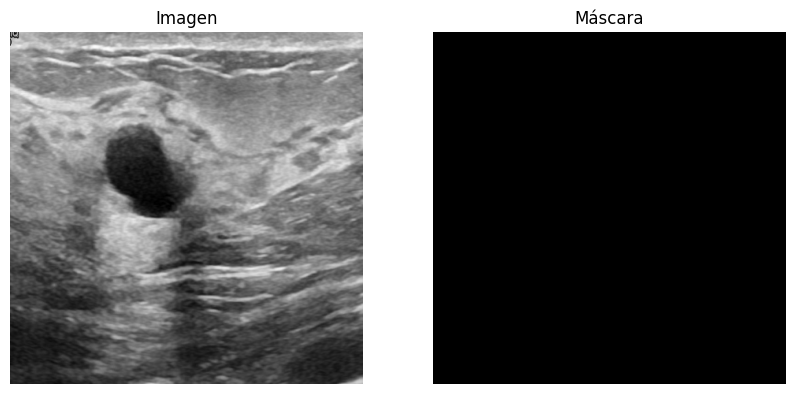

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


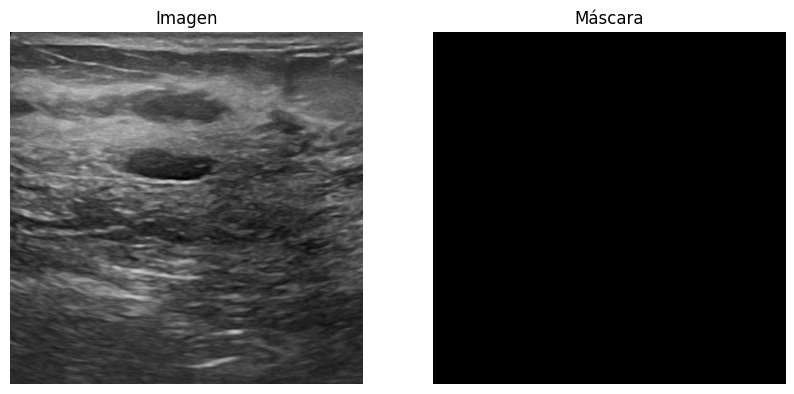

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


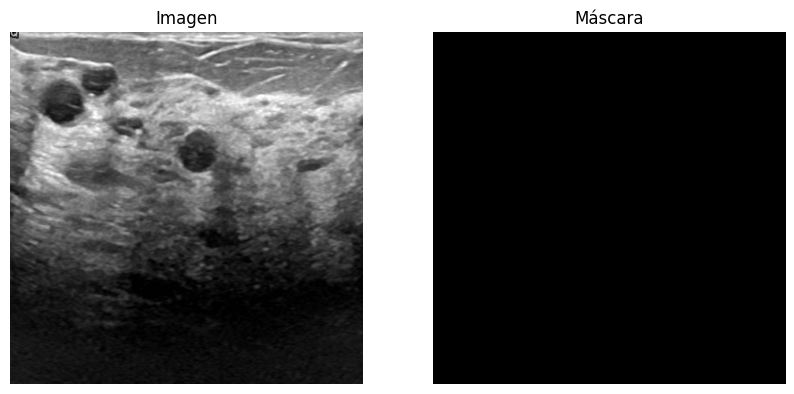

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


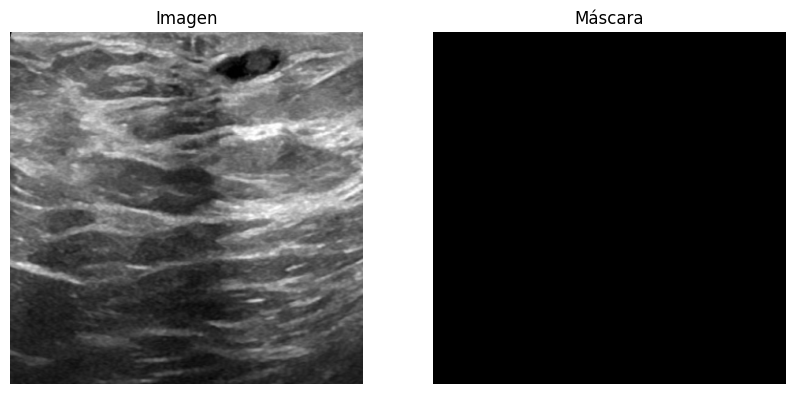

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


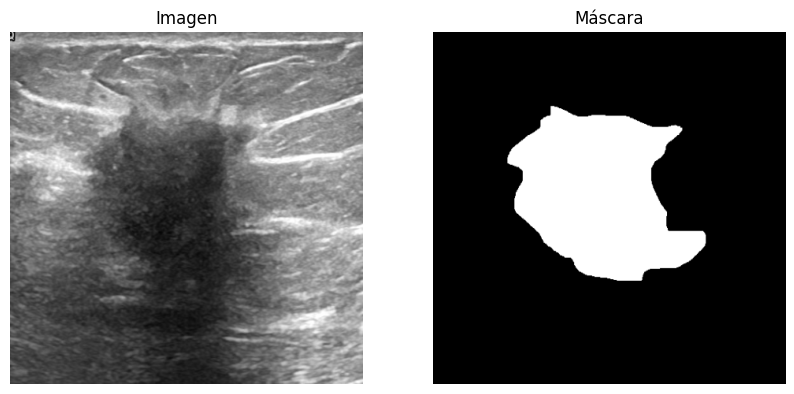

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


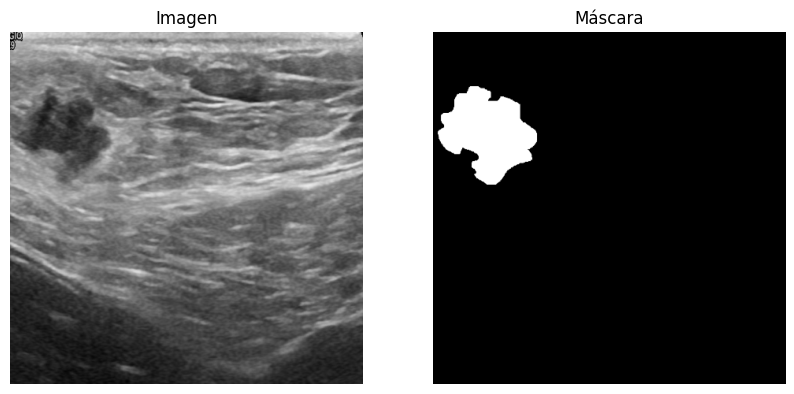

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


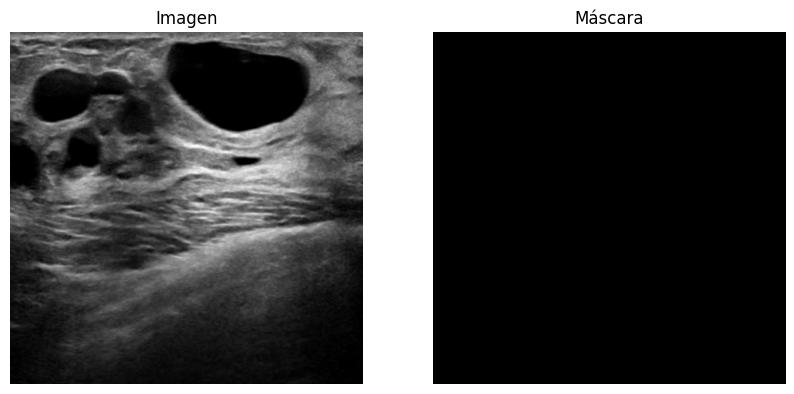

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


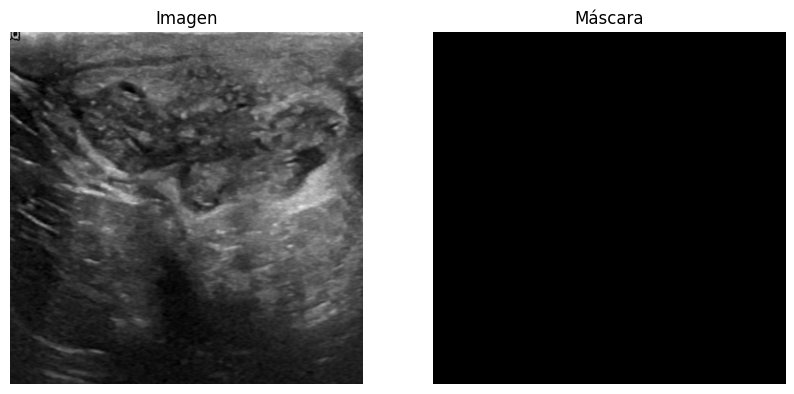

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


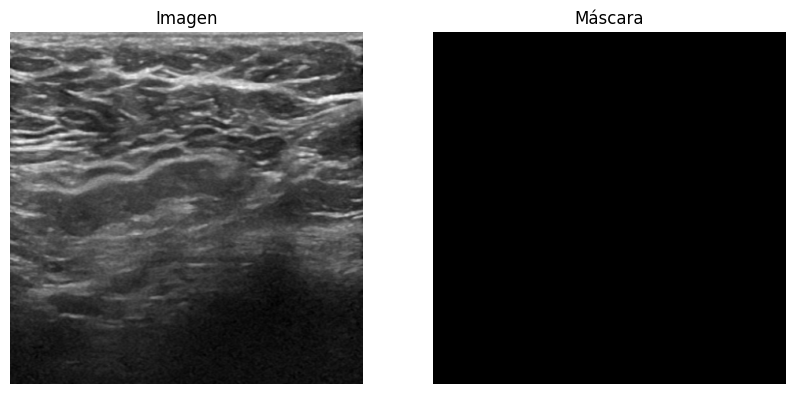

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


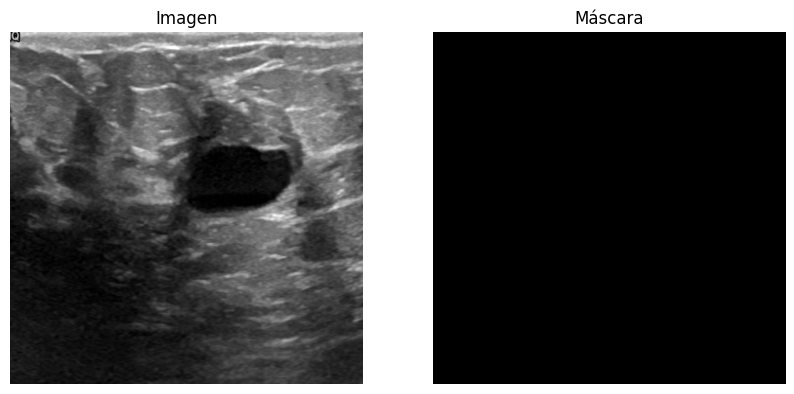

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


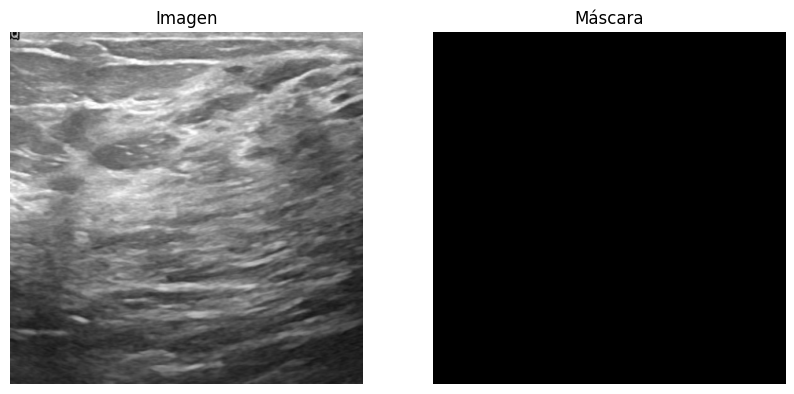

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


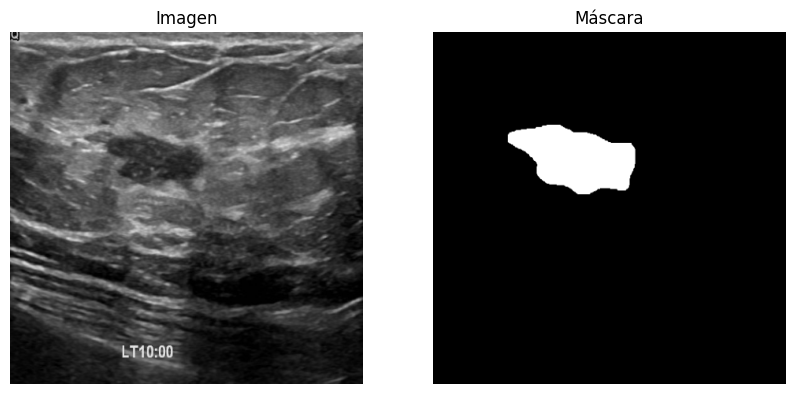

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


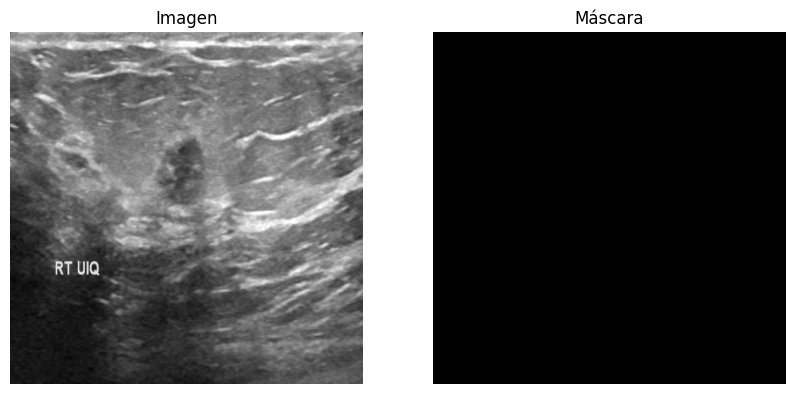

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


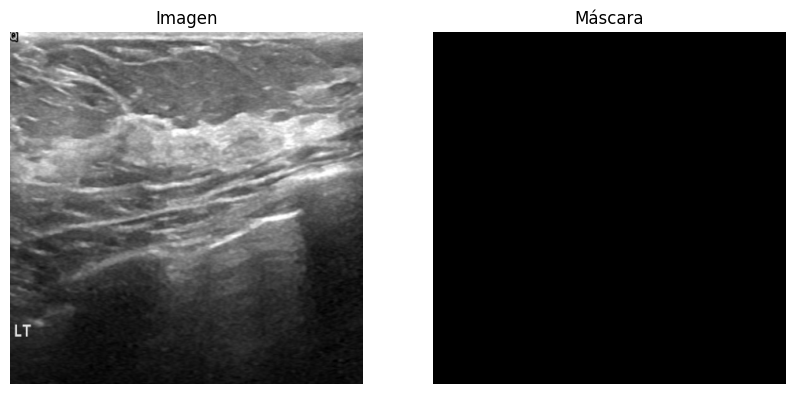

Tamaño de la imagen: (448, 448, 3), Tamaño de la máscara: (448, 448, 1)


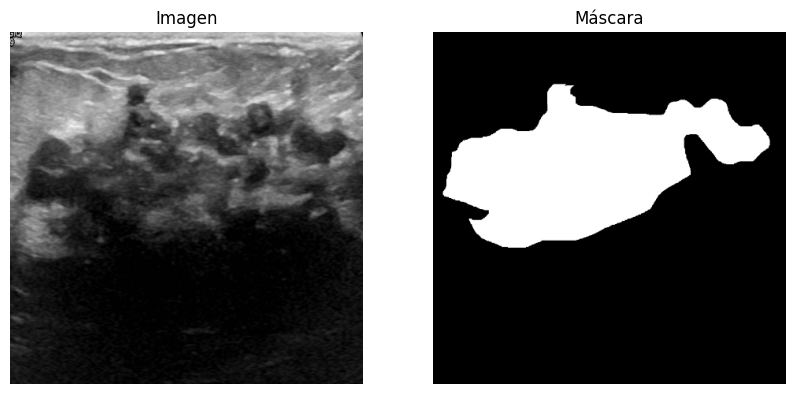

In [82]:
# Imprimir algunos ejemplos del conjunto de entrenamiento
num_examples_to_print = 15
for batch_image, batch_mask in train_dataset.take(1):  # Solo tomamos el primer lote
    for i in range(num_examples_to_print):
        # Extraer una imagen y su máscara del lote
        image = batch_image[i]
        mask = batch_mask[i]

        # Imprimir el tamaño de la imagen y la máscara
        print(f"Tamaño de la imagen: {image.shape}, Tamaño de la máscara: {mask.shape}")

        # Mostrar la imagen y la máscara utilizando matplotlib
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(image.numpy())
        plt.title('Imagen')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(mask.numpy().squeeze(), cmap='gray')  # Squeeze para eliminar la dimensión de canal
        plt.title('Máscara')
        plt.axis('off')

        plt.show()


In [89]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2

def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    x = Conv2D(filters = n_filters, kernel_size = kernel_size, kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def get_model(n_filters = 16, batchnorm = True, dropout = 0.1):

    inputs = Input(shape=(img_width, img_height, n_channels), name="input_image")

    # ENCODER: MobileNetV2
    encoder = MobileNetV2(input_tensor=inputs, include_top=False)

    BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/releases/download/v0.6/')
    model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)
    weight_path = BASE_WEIGHT_PATH + model_name
    weights_path = tf.keras.utils.get_file(model_name, weight_path)
    encoder.load_weights(weights_path, by_name=True, skip_mismatch=True)

    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    x = encoder_output

    x_skip_1 = encoder.get_layer(skip_connection_names[-1]).output  # 224x224
    x_skip_2 = encoder.get_layer(skip_connection_names[-2]).output  # 112x112
    x_skip_3 = encoder.get_layer(skip_connection_names[-3]).output  # 56x56
    x_skip_4 = encoder.get_layer(skip_connection_names[-4]).output  # 28x28

    # DECODER
    u6 = Conv2DTranspose(n_filters * 13, (3, 3), strides = (2, 2), padding = 'same')(x)
    u6 = concatenate([u6, x_skip_1])
    c6 = conv2d_block(u6, n_filters * 13, kernel_size = 3, batchnorm = batchnorm)
    p6 = Dropout(dropout)(c6)

    u7 = Conv2DTranspose(n_filters * 12, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, x_skip_2])
    c7 = conv2d_block(u7, n_filters * 12, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c7)

    u8 = Conv2DTranspose(n_filters * 11, (3, 3), strides = (2, 2), padding = 'same')(p7)
    u8 = concatenate([u8, x_skip_3])
    c8 = conv2d_block(u8, n_filters * 11, kernel_size = 3, batchnorm = batchnorm)
    p7 = Dropout(dropout)(c8)

    u9 = Conv2DTranspose(n_filters * 10, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, x_skip_4])
    c9 = conv2d_block(u9, n_filters * 10, kernel_size = 3, batchnorm = batchnorm)
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=inputs, outputs=outputs)
    model.summary()

    return model


In [84]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=n_classes)[Ellipsis,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [90]:
from tensorflow.keras.optimizers import Adam

# Crear el modelo
model = get_model(n_filters = 16, batchnorm = True, dropout = 0.1)

# Congelar los parámetros de las capas del codificador
encoder_layers = model.layers[0:-22]
for layer in encoder_layers:
    layer.trainable = False

# Compilar el modelo con el optimizador Adam
opt = Adam(learning_rate=0.001)
model.compile(loss=dice_loss, optimizer=opt, metrics=[dice_coef, 'accuracy'])

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 32, 32, 208), (None, 31, 31, 192)]

In [87]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_dice_coef', patience=20, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.2, patience=5, min_lr=0.00001)

model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs=20,
    steps_per_epoch=np.ceil(len(dftrain)/batch_size),
    validation_steps=np.ceil(len(dfval)/batch_size),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node model_7/conv2d_transpose_3/conv2d_transpose defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-87-08e6d04669f6>", line 7, in <cell line: 7>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/conv2d_transpose.py", line 296, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 6268, in conv2d_transpose

OOM when allocating tensor with shape[32,160,449,449] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_7/conv2d_transpose_3/conv2d_transpose}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_102032]

In [70]:
test_loss, test_medida = model.evaluate(test_dataset, verbose=2)
print("test_loss: %.4f, test_medida: %.4f" % (test_loss, test_medida))

3/3 - 1s - loss: 0.5847 - f1_metric: 0.7183 - 731ms/epoch - 244ms/step
test_loss: 0.5847, test_medida: 0.7183


In [71]:
# Directorio donde se encuentran las imágenes de prueba
test_images_dir = 'test/images/'

# Obtener la lista de nombres de archivos de las imágenes de prueba
test_filenames = os.listdir(test_images_dir)

# Crear un DataFrame para almacenar las predicciones
predictions_df = pd.DataFrame({'image_filename': test_filenames})

# Crear columnas para 'normal', 'benign' y 'malignant' con valores iniciales de 0
predictions_df['normal'] = 0
predictions_df['benign'] = 0
predictions_df['malignant'] = 0

# Iterar sobre cada imagen de prueba
for filename in test_filenames:
    # Cargar la imagen y preprocesarla
    img_path = os.path.join(test_images_dir, filename)
    img = load_img(img_path, target_size=(img_width, img_height))
    img_array = img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)  # Añadir una dimensión adicional para el lote

    # Realizar la predicción
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Obtener la clase predicha

    # Actualizar las columnas correspondientes según la predicción
    if predicted_class == 0:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'normal'] = 1
    elif predicted_class == 1:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'benign'] = 1
    elif predicted_class == 2:
        predictions_df.loc[predictions_df['image_filename'] == filename, 'malignant'] = 1

# Ordenar el DataFrame por el nombre del archivo de imagen
predictions_df = predictions_df.sort_values(by='image_filename')

# Guardar el DataFrame en un archivo CSV
predictions_df.to_csv('test_predictions.csv', index=False)

# Imprimir las primeras filas del DataFrame para verificar
print(predictions_df.head())


1/1 [==============================] - 0s 40ms/step
    image_filename  normal  benign  malignant
64   image_005.png       1       0          0
53   image_006.png       1       0          0
112  image_007.png       1       0          0
40   image_009.png       1       0          0
21   image_010.png       1       0          0
